In [1]:
!wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
!unzip imdb.zip
!pip -q install eli5
!pip -q install spacy
!python -m spacy download en

Archive:  imdb.zip
  inflating: test.tsv                
  inflating: train.tsv               
     |████████████████████████████████| 106 kB 29.2 MB/s 
     |████████████████████████████████| 12.0 MB 20.6 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


авторизация, запрос к гугл драйву

In [2]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '1d1-5FwxK53ePwygNWeG7jhsOWZbi5HOv'})
downloaded.GetContentFile('train_docs.pkl')

downloaded = drive.CreateFile({'id': '1MMOY477t965G0C5DtXeREVp0X85UaNq5'})
downloaded.GetContentFile('test_docs.pkl')

# Классификация текстов

Начнём с самого простого - анализа тональности текста.

Будем классифицировать отзывы с IMDB на положительные/отрицательные.

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [47]:
!head train.tsv

is_positive	review
0	"Dreamgirls, despite its fistful of Tony wins in an incredibly weak year on Broadway, has never been what one would call a jewel in the crown of stage musicals. However, that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers to the screen is basically a slavishly faithful version of the stage hit with all of its inherent weaknesses intact. First, the score has never been one of the strong points of this production and the film does not change that factor. There are lots of songs (perhaps too many?), but few of them are especially memorable. The closest any come to catchy tunes are the title song and One Night Only - the much acclaimed And I Am Telling You That I Am Not Going is less a great song than it is a dramatic set piece for the character of Effie (Jennifer Hudson). The film is slick and technically well-produced, but the story and characters are surprisi

In [48]:
import pandas as pd

train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


In [49]:
import numpy as np

Самое простое, как всегда - найти ключевые слова.

In [ ]:
#@title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = 'love', 'great', 'best', 'wonderful', 'favorite', 'exciting', 'fantastic', 'beautiful' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap', 'terrible', 'bad', 'stupid', 'horrid', 'boring' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))

Test accuracy = 71.46%


/usr/local/lib/python3.7/dist-packages/IPython/core/formatters.py:364: FormatterWarning: image/png formatter returned invalid type <class 'tuple'> (expected (<class 'bytes'>, <class 'str'>)) for object: <IPython.core.display.Image object>
  FormatterWarning


<IPython.core.display.Image object>

**Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!)

**Задание** Кому-нибудь нравятся эти `<br /><br />`? Лично мне - нет. Напишите регулярку, которая будет их удалять

In [50]:
import re

pattern = re.compile('<br />')

print(train_df['review'].iloc[3])
print(pattern.subn(' ', train_df['review'].iloc[3])[0])

Spoilers ahead if you want to call them that...<br /><br />I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top...<br /><br />THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no intensity or "effort".<br /><br />THE SCREENPLAY: I usually give credit to indie screenwriters, it's hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you'd uh...if you'd like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.<br /><br />THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take it one 

Применим ее:

In [51]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

Пора переходить к машинке!

Как будем представлять текст? Проще всего - мешком слов.

Заведём большой-большой словарь - список всех слов в обучающей выборке. Тогда каждое предложение можно представить в виде вектора, в котором будет записано, сколько раз встретилось каждое из возможных слов:

![bow](https://raw.githubusercontent.com/DanAnastasyev/DeepNLP-Course/master/Week%2001/Images/BOW.png)

Простой и приятный способ сделать это - запихнуть тексты в `CountVectorizer`.

Он имеет такую сигнатуру:

```python
CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=r'(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.int64'>)
```

Для начала обратим внимание на параметры `lowercase=True` и `max_df=1.0, min_df=1, max_features=None` - они про то, что по умолчанию все слова будут приводиться к нижнему регистру и в словарь попадут все слова, встречавшиеся в текстах.


In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

*Как именно vectorizer определяет границы слов? Обратите внимание на параметр `token_pattern=r'(?u)\b\w\w+\b'` - как он будет работать?*

Запустим его на реальных данных:

In [8]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [10]:
classifier = LogisticRegression()

In [11]:
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

Запустим на реальных данных.

In [12]:
model.fit(train_df['review'], train_df['is_positive'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
             

In [13]:
from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))
    
eval_model(model, test_df)

Test accuracy = 86.50%


Прогресс!

Хочется как-то посмотреть, что заинтересовало классификатор. К счастью, сделать это совсем просто:

In [15]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Посмотрим на конкретные примеры его работы:

In [ ]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [ ]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


Посмотрим на примеры неправильной классификации, наконец:

In [16]:
import numpy as np

preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

## Придумываем новые признаки

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.28%


In [ ]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=10)

In [ ]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.

**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [16]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.64%


Пробуем увеличенный range

In [20]:
vectorizer = TfidfVectorizer(ngram_range=(2, 3))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 86.40%


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(2, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 87.00%


Качество немного ухудшилось

### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы, не связываясь с этой вашей лингвистикой - только статистика, только хардкор.

**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Test accuracy = 87.86%


## Подключаем лингвистику

Убираем мусорные токены и обучим заново

In [17]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
stopwords_list = stopwords.words('english')

In [19]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize

In [20]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Поделим отзывы на токены с помощью nltk.tokenize.word_tokenize

In [21]:
train_df['review'] = train_df['review'].apply(lambda x: word_tokenize(str(x)))

In [22]:
train_df['review'] = train_df['review'].apply(lambda x: ' '.join([w for w in x if not w in stopwords_list]))

In [23]:
vectorizer = TfidfVectorizer(ngram_range=(2, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 81.14%


После того, как мы очистили токены от мусорных слов, качество модели ухудшилось.

### Лемматизация и стемминг

Если присмотреться, можно найти формы одного слова с разной семантической окраской по мнению классификатора. Или нет?

**Задание** Найти формы слова с разной семантической окраской.

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [52]:
import spacy
from spacy import displacy

nlp = spacy.load('en', disable=['parser'])

docs = [doc for doc in nlp.pipe(train_df.review.values)]

Сделаем классификатор на лемматизированных текстах.

In [30]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [31]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [32]:
train_df['review_lemm'] = train_df['review'].apply(lambda x:' '.join([lemmatizer.lemmatize(w) for w in x.split()]))

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review_lemm'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 86.80%


In [ ]:
vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review_lemm'], train_df['is_positive'])

eval_model(model, test_df)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Test accuracy = 80.69%


**Задание** Сделайте классификатор на лемматизированных текстах.

Более простой способ нормализации слов - использовать стемминг. Он немного тупой, не учитывает контекст, но иногда оказывается даже эффективнее лемматизации - а, главное, быстрее.

По сути это просто набор правил, как обрезать слово, чтобы получить основу (stem):

In [33]:
from nltk import PorterStemmer

stemmer = PorterStemmer()

print(stemmer.stem('become'))
print(stemmer.stem('becomes'))
print(stemmer.stem('became'))

becom
becom
becam


In [34]:
train_df['review_stem'] = train_df['review'].apply(lambda x:' '.join([stemmer.stem(w) for w in x.split()]))

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review_stem'], train_df['is_positive'])

eval_model(model, test_df)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Test accuracy = 86.62%


**Задание** Попробуйте вместо лемм классифицировать основы.

### NER

В текстах рецензий очень много именованных сущностей.

Вообще говоря, почему вдруг какой-нибудь Депп должен нести семантическую окраску? Однако оказывается, что классификатор выучивает, что какие-то имена чаще в положительных рецензиях - или наоборот. Это похоже на переобучение - почему бы не попробовать вырезать сущности?

**Задание** Удалите из текстов какие-то из сущностей, пользуясь координатами из запикленных файлов. Описание сущностей можно посмотреть [здесь](https://spacy.io/api/annotation#named-entities). Запустите классификатор.

In [97]:
def check_ent(docs):
    try:
      for i, elem  in enumerate(docs):
        ents = ["PERSON", "GPE","ORG"]
        docs[i] =  " ".join([token.text for token in docs[i] if token.ent_type_ not in ents])
    except BaseException as e:
        print('Error: '+ str(e))

In [104]:
train_df['review'] = docs

In [105]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Test accuracy = 87.09%


После удаления из текстов некоторых именованных сущностей, точность модели выросла и составила **87.09%**

## Включаем дип лёрнинг

In [107]:
train_df['review']

0        , despite its fistful of wins in an incredibly...
1        This show comes up with interesting locations ...
2        I simply love this movie . I also love the Ram...
3        Spoilers ahead if you want to call them that ....
4        My all - time favorite movie ! I have seen man...
                               ...                        
24995    I am a big fan of the movie , but not for the ...
24996    I 'm not going to bother with a plot synopsis ...
24997    This movie . . . I do n't know . Why they woul...
24998    Saw this film on DVD yesterday and was gob - s...
24999    This was a disappointment - none of the nuance...
Name: review, Length: 25000, dtype: object

<a list of 204 Patch objects>

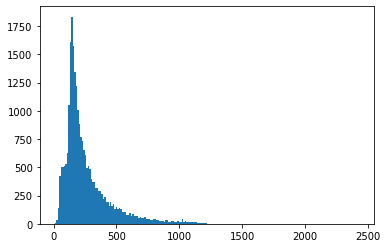

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

Кроме этого, нужно перенумеровать как-то слова.

In [109]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 16401


**Задание** Сконвертируйте данные

In [110]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

In [111]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [112]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

In [113]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 64)          1049664   
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                650       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,050,435
Trainable params: 1,050,435
Non-trainable params: 0
_________________________________________________________________


In [114]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 12s 45ms/step - loss: 0.5767 - accuracy: 0.7572 - val_loss: 0.4020 - val_accuracy: 0.8248
Epoch 2/10
196/196 [==============================] - 8s 43ms/step - loss: 0.2863 - accuracy: 0.8826 - val_loss: 0.3303 - val_accuracy: 0.8544
Epoch 3/10
196/196 [==============================] - 8s 43ms/step - loss: 0.1969 - accuracy: 0.9233 - val_loss: 0.3332 - val_accuracy: 0.8570
Epoch 4/10
196/196 [==============================] - 8s 42ms/step - loss: 0.1314 - accuracy: 0.9539 - val_loss: 0.3534 - val_accuracy: 0.8578
Epoch 5/10
196/196 [==============================] - 8s 42ms/step - loss: 0.0806 - accuracy: 0.9764 - val_loss: 0.4015 - val_accuracy: 0.8516
Epoch 6/10
196/196 [==============================] - 8s 42ms/step - loss: 0.0446 - accuracy: 0.9901 - val_loss: 0.4531 - val_accuracy: 0.8492
Epoch 7/10
196/196 [==============================] - 8s 43ms/step - loss: 0.0226 - accuracy: 0.9970 - val_loss: 0.4981 - val_accuracy: 0.846

**Задание** Подсчитайте качество модели на тесте

In [115]:
test_loss, test_acc = model.evaluate(X_test, test_df.is_positive, verbose=2)

print('\nTest accuracy:', test_acc)

782/782 - 3s - loss: 0.6162 - accuracy: 0.8454

Test accuracy: 0.8453999757766724
